# Vortex Profile

### Import libraries

In [1]:
import random
from math import pi

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

## Vortex models

There are several ways to model a 2D vortex. 

### Lamb-Oseen model

https://en.wikipedia.org/wiki/Lamb%E2%80%93Oseen_vortex

Here, we are only interested in the simplified cylindrical form of the Lamb-Oseen model:

$V(r) = \frac{\Gamma} {2 {\pi}} (1 - exp(-\frac{r^2}{r_c^2}))$

where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [2]:
def lamb_oseen(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = distance_from_core in m
    returns the tangential velocity
    """
    # Small manipulation to avoid the case r = 0 below 
    r_new = (r == 0).astype(int) / 1000 + r
    return gamma / (2 * pi * r_new) * (1 - np.exp( - r ** 2 / rc ** 2))

### Rankine model

https://en.wikipedia.org/wiki/Rankine_vortex

The drawback the rankine model is its non-linearity. Therefore it won't be used.

$V(r) = \frac{\Gamma r}{2 {\pi} r_c^2} $ for $r \le R $

$V(r) = \frac{\Gamma}{2 {\pi} r} $ if $ for > R $


where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [3]:
def rankine(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = distance_from_core in m
    returns the tangential velocity
    """
    internal_V = (abs(r) <= rc).astype(int) * gamma * r /( 2 * pi * rc**2)
    # Small manipulation to avoid the case r = 0 below 
    r_new = (r == 0).astype(int) / 1000 + r
    external_V = (abs(r) > rc).astype(int) * gamma / (2 * pi * r_new)
    return internal_V + external_V

### Burnham-Hallock model

The Burnham-Hallock model is commonly used for aircraft wake vortices.

$V(r)=\frac{\Gamma}{2{\pi}r}\frac{r^2}{r^2+r_c^2}$

where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex core
- ${r_c}$ is the mean vortex core, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [4]:
def burnham_hallock(gamma, rc, r):
    """
    gamma = circulation in m^2/s
    rc = core_radius in m
    r = distance_from_core in m
    returns the tangential velocity
    """
    return gamma / (2 * pi) * r / (r ** 2 + rc ** 2)

### Comparison of the models

Let's define a vortex with 300m^2/s circulation and a core radius of 4m between -20m and 20m and plot the vortex profile

In [5]:
r_max = 20
r_min = -r_max
r_step = 0.5

total_circulation = 300
core_radius = 4

distance_from_core = np.arange(r_min, r_max+r_step, r_step)

velocity_lo = lamb_oseen(total_circulation, core_radius, distance_from_core)
velocity_ra = rankine(total_circulation, core_radius, distance_from_core)
velocity_bh = burnham_hallock(total_circulation, core_radius, distance_from_core)

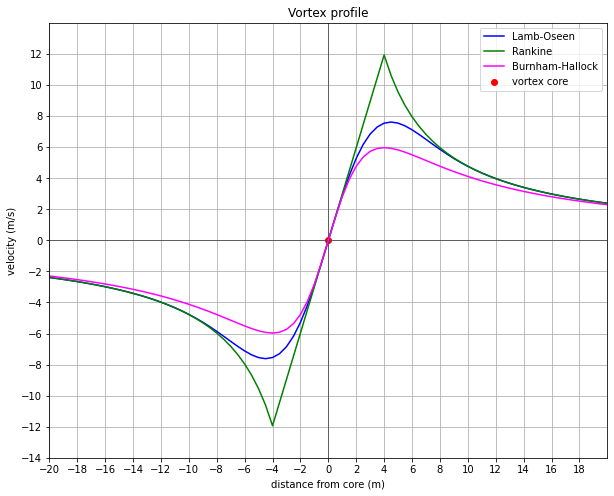

In [6]:
%matplotlib inline

y_max = int(max(np.max(velocity_lo), np.max(velocity_ra), np.max(velocity_bh)) / 2) * 2 + 4
x_max = r_max

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 2)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.plot(distance_from_core, velocity_lo, color='blue', label='Lamb-Oseen')
ax.plot(distance_from_core, velocity_ra, color='green', label='Rankine')
ax.plot(distance_from_core, velocity_bh, color='magenta', label='Burnham-Hallock')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_burnham_hallock_profile.png")
plt.legend()
plt.show()

## Reconstruction of a LiDAR envelope

The analysis of aircraft wake vortices is made using data provided by post-processing of LiDAR measurements. These data consist of envelopes of the measured velocity as a function of the distance from the assumed position of the vortex core.

To make the data more realistic, following additional parameters must be added to the model equations:
- random background noise
- core shift $\Delta r_c$
- velocity shift $\Delta V$
- random error around the calculted profile $\delta \epsilon_V$

The measurements are discrete, that means, that we obtained points on the velocity profile at a regular interval, the so-called LiDAR resolution.

In [7]:
def add_noise_to_envelope(velocity):
    """
    Add noise to the envelope.
    Noise is assumed to be 2 m/s
    The envelope is crossing the y=0 only in the core
    """
    noise = np.random.normal(1, 0.25, velocity.shape) * np.sign(velocity)
    return np.maximum(np.abs(velocity), noise) * np.sign(velocity)

In [8]:
def add_shift():
    """
    Returns two random numbers for core and velocity shift
    """
    return random.gauss(0, 0.25), random.gauss(0, 0.25)

In [9]:
def add_random_error(velocity):
    """
    Add random error to the velocity profile
    An error of +/- 0.5 m/s is added to the profile
    """
    return velocity + np.random.normal(0, 0.25, velocity.shape)

In [10]:
def generate_lidar_envelope(Gamma, rc, r, model=burnham_hallock):
    Delta_r, Delta_V = add_shift()
    # core shift
    r -= Delta_r
    # Velocity profile
    velocity_profile = model(Gamma, rc, r)
    # add the noise
    velocity_profile = add_noise_to_envelope(velocity_profile)
    # add the random_error
    velocity_profile = add_random_error(velocity_profile)
    # Velocity shift
    return velocity_profile + Delta_V, Delta_r, Delta_V

In [11]:
def set_lidar_resolution():
    return random.uniform(1, 3)

Let's define a vortex with 300m^2/s circulation and a core radius of 3m between -100m and 100m and plot the vortex profile with the LiDAR envelope.

For this exercise, we use a Burnham-Hallock profile

In [12]:
r_max = 100
r_min = -r_max
r_step = set_lidar_resolution()

total_circulation = 300
core_radius = 4

distance_from_core = np.arange(r_min, r_max+r_step, r_step)
distance_from_core_model = np.arange(r_min, r_max+1, 0.5)

velocity_lidar, Delta_r, Delta_V = generate_lidar_envelope(total_circulation, core_radius, distance_from_core)
velocity_model = burnham_hallock(total_circulation, core_radius, distance_from_core_model)

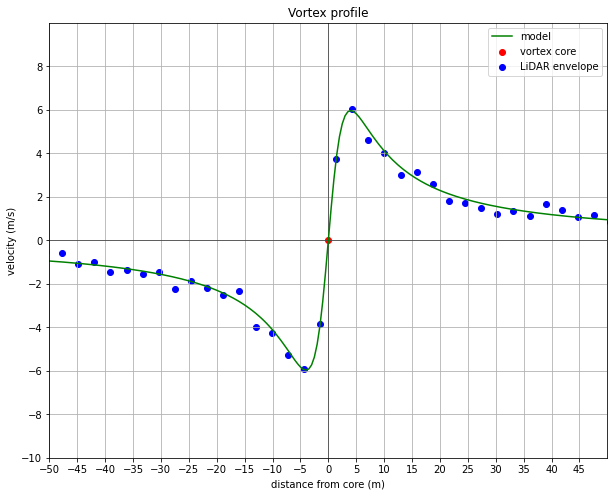

In [13]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.scatter(distance_from_core, velocity_lidar, color='blue', label='LiDAR envelope')
ax.plot(distance_from_core_model, velocity_model, color='green', label='model')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope.png")
plt.legend()
plt.show()

## Fitting of the LiDAR profile

The current step consists in doing the other way: from the reconstructed LiDAR profile, we will fit the data to estimate the original vortex characteristics

The adapted Burnham-Hallock model fitting the reconstructed data or the vortex profile data obtained from the LiDAR processing looks like:

$V(r)=\frac{\Gamma}{2{\pi}(r-\Delta r_c)}\frac{(r-\Delta r_c)^2}{(r-\Delta r_c)^2+r_c^2} + \Delta V$ 

Therefore, there are 4 unknown for this equation:
- $\Gamma$, the total circulation of the vortex
- $r_c$, the core radius of the vortex
- $\Delta r_c$, the shift in the direction of the r coordinate
- $\Delta V$, the velocity shift

### First estimation of the velocity peaks
The positions of the maximum and minimum velocity are read from the LiDAR profile.

In [14]:
def get_min_max_index(velocity_lidar):
    return np.argmin(velocity_lidar), np.argmax(velocity_lidar)

In [15]:
def get_min_max_radii(distance_from_core, velocity_lidar):
    idx_min, idx_max = get_min_max_index(velocity_lidar)
    return distance_from_core[idx_min], distance_from_core[idx_max]

In [16]:
def get_min_max_velocity(velocity_lidar):
    return np.min(velocity_lidar), np.max(velocity_lidar)

### Estimation of the mean velocities
The mean velocity is the mean of the absolute velocity.

Positive and negative mean velocities outside the vortex core are calculated separately.

In [17]:
def get_abs_mean_velocity(velocity_lidar):
    return np.mean(np.abs(velocity_lidar))

In [18]:
def get_neg_pos_mean_velocities(velocity_lidar):
    idx_min, idx_max = get_min_max_index(velocity_lidar)
    return np.mean(velocity_lidar[:idx_min+1]), np.mean(velocity_lidar[idx_max:])

### Dismissing of outliers
#### Noise - Cuf-off
First, points far from the core are not to be separated from the noise. A cut-off is introduced under the following assumptions:
- Only a small of points is measured around the core,
- Their velocities are bigger than the noise,
- In that case, the mean velocity is slighty bigger than the noise,
- Every point under the mean velocity may therefore be considered as an outlier and has to be dismissed,
- To avoid an early cut-off due to a single outlier, there must be at least 3 points in a row under the mean velocity to locate the cut-off position.
- Points at the limit of the window are considered to be noise.
- Points inside vortex core with velocity smaller than the mean velocity are also dismissed as noise.

This method is used for positive and negative velocities separately.

In [19]:
def selection_of_points(velocity_lidar):
    v_neg_mean, v_pos_mean = get_neg_pos_mean_velocities(velocity_lidar)
    idx_min, idx_max = get_min_max_index(velocity_lidar)
    
    selected_neg_points = (velocity_lidar <= v_neg_mean).astype(int)\
                        * (np.append((velocity_lidar[1:] <= v_neg_mean).astype(int), np.zeros(1))\
                         + np.append((velocity_lidar[2:] <= v_neg_mean).astype(int), np.zeros(2))\
                         + np.append((velocity_lidar[3:] <= v_neg_mean).astype(int), np.zeros(3)))
    selected_pos_points = (velocity_lidar >= v_pos_mean).astype(int)\
                        * (np.append(np.zeros(1), (velocity_lidar[:-1] >= v_pos_mean).astype(int))\
                         + np.append(np.zeros(2), (velocity_lidar[:-2] >= v_pos_mean).astype(int))\
                         + np.append(np.zeros(3), (velocity_lidar[:-3] >= v_pos_mean).astype(int)))
    
    selected_core_points = np.concatenate((np.zeros(idx_min), 
                                           np.abs(velocity_lidar[idx_min:idx_max]) >= 
                                               0.5 * (v_pos_mean - v_neg_mean), 
                                           np.zeros(velocity_lidar.shape - idx_max)))
    
    return selected_neg_points + selected_pos_points + selected_core_points

In [20]:
def dismiss_values_from_vectors(vector, selected_points, velocity_lidar):
    idx_min, idx_max = get_min_max_index(velocity_lidar)
    idx_core = np.where(selected_points[idx_min:idx_max] == 0)
    
    idx_start = np.where(selected_points[:idx_min] >= 2)[0][0]
    idx_end = np.where(selected_points[idx_max:] >= 2)[0][-1] + idx_max

    if idx_core[0].size == 0:
        return vector[idx_start:idx_end+1]
    
    idx_core_min = idx_core[0][0] + idx_min
    idx_core_max = idx_core[0][-1] + idx_min
    
    return np.concatenate((vector[idx_start:idx_core_min], vector[idx_core_max+1:idx_end+1]))

In [21]:
selected_points = selection_of_points(velocity_lidar)
distance_for_fitting = dismiss_values_from_vectors(distance_from_core, selected_points, velocity_lidar)
velocity_for_fitting = dismiss_values_from_vectors(velocity_lidar, selected_points, velocity_lidar)

In [22]:
v_neg_mean, v_pos_mean = get_neg_pos_mean_velocities(velocity_lidar)

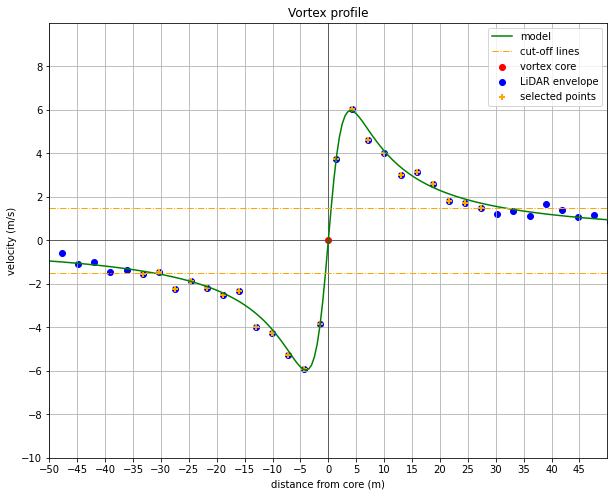

In [23]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.scatter(distance_from_core, velocity_lidar, color='blue', label='LiDAR envelope')
ax.scatter(distance_for_fitting, velocity_for_fitting, marker='+', color='orange', \
           lw=2, label='selected points')
ax.plot(distance_from_core_model, velocity_model, color='green', label='model')

plt.axhline(v_neg_mean, color='orange', lw=1, ls='-.', label='cut-off lines')
plt.axhline(v_pos_mean, color='orange', lw=1, ls='-.')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope_with_selected_points.png")
plt.legend()
plt.show()

### Definition of the profile function

In [24]:
def modified_burnham_hallock(r, gamma, rc, delta_r, delta_V):
    return gamma / (2 * pi) * (r - delta_r) / ( (r - delta_r )** 2 + rc**2) + delta_V

### Fit the LiDAR profile with a built-in function

In [25]:
fitted_values, pcov = curve_fit(modified_burnham_hallock, 
                                distance_for_fitting, 
                                velocity_for_fitting, 
                                p0 = [100,1,0,0])

#### Comparison of results with initial data

In [26]:
original_values = [total_circulation, core_radius, Delta_r, Delta_V]

comparison_table = pd.DataFrame({'Original': original_values, 'Fit': fitted_values, 
                                 'Error': original_values - fitted_values,
                                 'Rel. error': 100 * (original_values - fitted_values) / original_values},
                                index=['Total circulation', 'Core radius', 'Delta_r', 'Delta_V'])

In [27]:
comparison_table.round(2)

,Original,Fit,Error,Rel. error
Total circulation,300.00,299.96,0.04,0.01
Core radius,4.00,4.02,-0.02,-0.38
Delta_r,-0.29,-0.09,-0.21,70.53
Delta_V,-0.04,-0.11,0.07,-165.02


Based on these original values, core radius and total circulation are well estimated.

In [28]:
velocity_from_fitting = modified_burnham_hallock(distance_for_fitting, 
                                                 total_circulation, 
                                                 core_radius, 
                                                 Delta_r, Delta_V)

mean_squared_error(velocity_for_fitting, velocity_from_fitting) 

0.08835417189558493

In [29]:
velocity_from_fitting = modified_burnham_hallock(distance_from_core_model, 
                                                 total_circulation, 
                                                 core_radius, 
                                                 Delta_r, Delta_V)

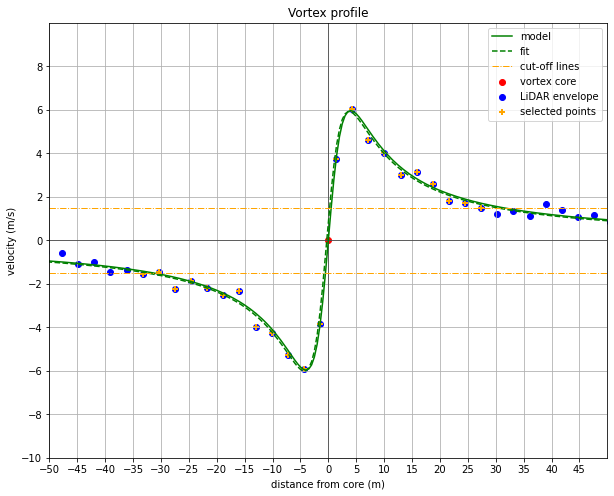

In [30]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex core')

ax.scatter(distance_from_core, velocity_lidar, color='blue', label='LiDAR envelope')
ax.scatter(distance_for_fitting, velocity_for_fitting, marker='+', color='orange', \
           lw=2, label='selected points')
ax.plot(distance_from_core_model, velocity_model, color='green', label='model')
ax.plot(distance_from_core_model, velocity_from_fitting, color='green', ls='--', label='fit')

plt.axhline(v_neg_mean, color='orange', lw=1, ls='-.', label='cut-off lines')
plt.axhline(v_pos_mean, color='orange', lw=1, ls='-.')

ax.set(xlabel='distance from core (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope_with_fit.png")
plt.legend()
plt.show()